# House Prices Advanced Regression Techniques
資料來源:https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data


# 匯入工具

In [318]:
import numpy as np
import pandas as pd
import datetime

import random
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.kernel_ridge import KernelRidge

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet 

from sklearn.svm import SVR

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

import lightgbm as lgb

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

pd.set_option('display.max_columns', None)
%matplotlib inline

# 匯入資料

In [568]:
# 匯入資料後先把資料顯示出來看看長什麼樣子
# 從下面可以看到有許多文字型的資料
# 這個案例是要預測房價屬於regression的問題

mydata = pd.read_csv("train.csv")
mydata.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# 資料預處理

先挑選一個明顯和房價有關係的feature觀察對房價的影響
這裡選擇GrLivArea( Above grade (ground) living area square feet )來觀察

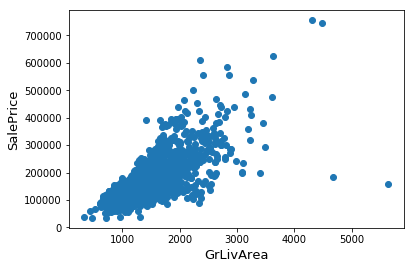

In [569]:
# 圖中右下明顯有兩個異常點，幾乎和房價沒關係

fig, ax = plt.subplots()
ax.scatter(x = mydata['GrLivArea'], y = mydata['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

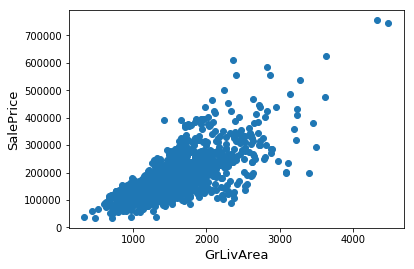

In [570]:
# 透過從上圖中可以觀察到的門檻值來刪除那兩個異常點

mydata = mydata.drop(mydata[(mydata['GrLivArea']>4000) & (mydata['SalePrice']<300000)].index)

# 觀察刪除後的資料
fig, ax = plt.subplots()
ax.scatter(mydata['GrLivArea'], mydata['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

檢查空值 & 文字資料轉成數值表示

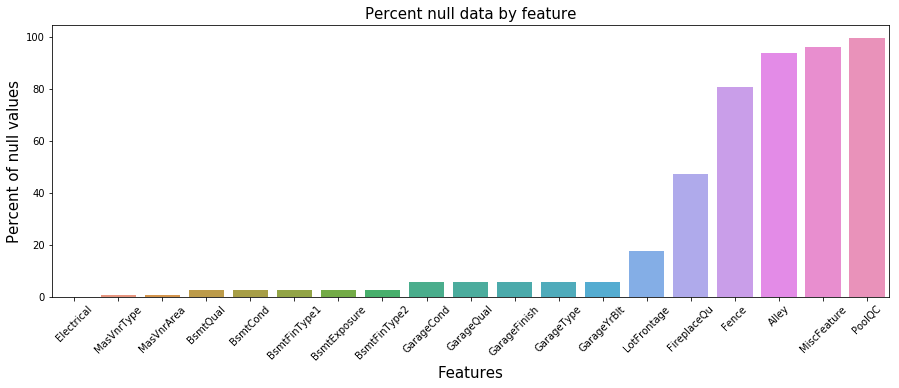

In [571]:
# 這裡可以看到雖然PoolQC高達90%都沒有資料
# 不過這裡只是代表房子沒有泳池
# 直接刪掉可能會損失重要的feature
# 先將文字和空值填補後再來分析哪些feature沒用

import seaborn as sns

all_data_na = (mydata.isnull().sum() / len(mydata)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=True)

f, ax = plt.subplots(figsize=(15, 5))
plt.xticks(rotation='45')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of null values', fontsize=15)
plt.title('Percent null data by feature', fontsize=15)

處理有空值的資料並把文字資料轉成值
參考來源:https://www.kaggle.com/agehsbarg/top-10-0-10943-stacking-mice-and-brutal-force

In [572]:
# 不是所有空值都代表資料遺失
# 根據kaggle上對資料的解釋有些是房子沒有這項設施
# 在這個案例中對這些資料一個一個進行處理
# 原本我的方法是讓他等於0或是平均
# 測試過後效果不好
# 這裡參考其他作者kaggle kernel的資料預處理方式

from sklearn.preprocessing import LabelEncoder

def fill_missings(res):

    res['Alley'] = res['Alley'].fillna('missing')
    res['PoolQC'] = res['PoolQC'].fillna(res['PoolQC'].mode()[0])
    res['MasVnrType'] = res['MasVnrType'].fillna('None')
    res['BsmtQual'] = res['BsmtQual'].fillna(res['BsmtQual'].mode()[0])
    res['BsmtCond'] = res['BsmtCond'].fillna(res['BsmtCond'].mode()[0])
    res['FireplaceQu'] = res['FireplaceQu'].fillna(res['FireplaceQu'].mode()[0])
    res['GarageType'] = res['GarageType'].fillna('missing')
    res['GarageFinish'] = res['GarageFinish'].fillna(res['GarageFinish'].mode()[0])
    res['GarageQual'] = res['GarageQual'].fillna(res['GarageQual'].mode()[0])
    res['GarageCond'] = res['GarageCond'].fillna('missing')
    res['Fence'] = res['Fence'].fillna('missing')
    res['Street'] = res['Street'].fillna('missing')
    res['LotShape'] = res['LotShape'].fillna('missing')
    res['LandContour'] = res['LandContour'].fillna('missing')
    res['BsmtExposure'] = res['BsmtExposure'].fillna(res['BsmtExposure'].mode()[0])
    res['BsmtFinType1'] = res['BsmtFinType1'].fillna('missing')
    res['BsmtFinType2'] = res['BsmtFinType2'].fillna('missing')
    res['CentralAir'] = res['CentralAir'].fillna('missing')
    res['Electrical'] = res['Electrical'].fillna(res['Electrical'].mode()[0])
    res['MiscFeature'] = res['MiscFeature'].fillna('missing')
    res['MSZoning'] = res['MSZoning'].fillna(res['MSZoning'].mode()[0])    
    res['Utilities'] = res['Utilities'].fillna('missing')
    res['Exterior1st'] = res['Exterior1st'].fillna(res['Exterior1st'].mode()[0])
    res['Exterior2nd'] = res['Exterior2nd'].fillna(res['Exterior2nd'].mode()[0])    
    res['KitchenQual'] = res['KitchenQual'].fillna(res['KitchenQual'].mode()[0])
    res["Functional"] = res["Functional"].fillna("Typ")
    res['SaleType'] = res['SaleType'].fillna(res['SaleType'].mode()[0])
    res['SaleCondition'] = res['SaleCondition'].fillna('missing')
    
    flist = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
                     'TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea',
                     'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr',
                     'TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF',
                     'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal']
    for fl in flist:
        res[fl] = res[fl].fillna(0)
        
    res['TotalBsmtSF'] = res['TotalBsmtSF'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
    res['2ndFlrSF'] = res['2ndFlrSF'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)
    res['GarageArea'] = res['GarageArea'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
    res['GarageCars'] = res['GarageCars'].apply(lambda x: 0 if x <= 0.0 else x)
    res['LotFrontage'] = res['LotFrontage'].apply(lambda x: np.exp(4.2) if x <= 0.0 else x)
    res['MasVnrArea'] = res['MasVnrArea'].apply(lambda x: np.exp(4) if x <= 0.0 else x)
    res['BsmtFinSF1'] = res['BsmtFinSF1'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)
    
      
    return res


In [573]:
# 將'TotalBsmtSF' '1stFlrSF' '2ndFlrSF'加起來變成一個feature

mydata = fill_missings(mydata)
mydata['TotalSF'] = mydata['TotalBsmtSF'] + mydata['1stFlrSF'] + mydata['2ndFlrSF']

# 有一些文字型態資料可以被encoding為一段連續數值
# 因為在原本資料的意義就有分級的關係
# 在這裡分析文字資料的內容將其label轉換成相對較合適的數值


# i.e. 這裡label在意義上的關係為 Ex>Gd>TA>Fa
#      具有一個大小分級上的關係，encoding為一連續數值是合理的
def QualToInt(x):
    if(x=='Ex'):
        r = 0
    elif(x=='Gd'):
        r = 1
    elif(x=='TA'):
        r = 2
    elif(x=='Fa'):
        r = 3
    elif(x=='missing'):
        r = 4
    else:
        r = 5
    return r

mydata['ExterQual'] = mydata['ExterQual'].apply(QualToInt)
mydata['ExterCond'] = mydata['ExterCond'].apply(QualToInt)
mydata['KitchenQual'] = mydata['KitchenQual'].apply(QualToInt)
mydata['HeatingQC'] = mydata['HeatingQC'].apply(QualToInt)
mydata['BsmtQual'] = mydata['BsmtQual'].apply(QualToInt)
mydata['BsmtCond'] = mydata['BsmtCond'].apply(QualToInt)
mydata['FireplaceQu'] = mydata['FireplaceQu'].apply(QualToInt)
mydata['GarageQual'] = mydata['GarageQual'].apply(QualToInt)
mydata['PoolQC'] = mydata['PoolQC'].apply(QualToInt)

def SlopeToInt(x):
    if(x=='Gtl'):
        r = 0
    elif(x=='Mod'):
        r = 1
    elif(x=='Sev'):
        r = 2
    else:
        r = 3
    return r

mydata['LandSlope'] = mydata['LandSlope'].apply(SlopeToInt)
mydata['CentralAir'] = mydata['CentralAir'].apply( lambda x: 0 if x == 'N' else 1) 
mydata['Street'] = mydata['Street'].apply( lambda x: 0 if x == 'Pave' else 1) 
mydata['PavedDrive'] = mydata['PavedDrive'].apply( lambda x: 0 if x == 'Y' else 1)

def GFinishToInt(x):
    if(x=='Fin'):
        r = 0
    elif(x=='RFn'):
        r = 1
    elif(x=='Unf'):
        r = 2
    else:
        r = 3
    return r

mydata['GarageFinish'] = mydata['GarageFinish'].apply(GFinishToInt)

def BsmtExposureToInt(x):
    if(x=='Gd'):
        r = 0
    elif(x=='Av'):
        r = 1
    elif(x=='Mn'):
        r = 2
    elif(x=='No'):
        r = 3
    else:
        r = 4
    return r
mydata['BsmtExposure'] = mydata['BsmtExposure'].apply(BsmtExposureToInt)

def FunctionalToInt(x):
    if(x=='Typ'):
        r = 0
    elif(x=='Min1'):
        r = 1
    elif(x=='Min2'):
        r = 1
    else:
        r = 2
    return r

mydata['Functional_int'] = mydata['Functional'].apply(FunctionalToInt)


def HouseStyleToInt(x):
    if(x=='1.5Unf'):
        r = 0
    elif(x=='SFoyer'):
        r = 1
    elif(x=='1.5Fin'):
        r = 2
    elif(x=='2.5Unf'):
        r = 3
    elif(x=='SLvl'):
        r = 4
    elif(x=='1Story'):
        r = 5
    elif(x=='2Story'):
        r = 6  
    elif(x==' 2.5Fin'):
        r = 7          
    else:
        r = 8
    return r

mydata['HouseStyle_int'] = mydata['HouseStyle'].apply(HouseStyleToInt)
mydata['HouseStyle_1st'] = 1*(mydata['HouseStyle'] == '1Story')
mydata['HouseStyle_2st'] = 1*(mydata['HouseStyle'] == '2Story')
mydata['HouseStyle_15st'] = 1*(mydata['HouseStyle'] == '1.5Fin')

def FoundationToInt(x):
    if(x=='PConc'):
        r = 3
    elif(x=='CBlock'):
        r = 2
    elif(x=='BrkTil'):
        r = 1        
    else:
        r = 0
    return r

mydata['Foundation_int'] = mydata['Foundation'].apply(FoundationToInt)

def MasVnrTypeToInt(x):
    if(x=='Stone'):
        r = 3
    elif(x=='BrkFace'):
        r = 2
    elif(x=='BrkCmn'):
        r = 1        
    else:
        r = 0
    return r

mydata['MasVnrType_int'] = mydata['MasVnrType'].apply(MasVnrTypeToInt)

def BsmtFinType1ToInt(x):
    if(x=='GLQ'):
        r = 6
    elif(x=='ALQ'):
        r = 5
    elif(x=='BLQ'):
        r = 4
    elif(x=='Rec'):
        r = 3   
    elif(x=='LwQ'):
        r = 2
    elif(x=='Unf'):
        r = 1        
    else:
        r = 0
    return r

mydata['BsmtFinType1_int'] = mydata['BsmtFinType1'].apply(BsmtFinType1ToInt)
mydata['BsmtFinType1_Unf'] = 1*(mydata['BsmtFinType1'] == 'Unf')
mydata['HasWoodDeck'] = (mydata['WoodDeckSF'] == 0) * 1
mydata['HasOpenPorch'] = (mydata['OpenPorchSF'] == 0) * 1
mydata['HasEnclosedPorch'] = (mydata['EnclosedPorch'] == 0) * 1
mydata['Has3SsnPorch'] = (mydata['3SsnPorch'] == 0) * 1
mydata['HasScreenPorch'] = (mydata['ScreenPorch'] == 0) * 1
mydata['YearsSinceRemodel'] = mydata['YrSold'].astype(int) - mydata['YearRemodAdd'].astype(int)
mydata['Total_Home_Quality'] = mydata['OverallQual'] + mydata['OverallCond']

In [574]:
# 將feature經過log可以減少離群值

def addlogs(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(np.log(1.01+res[l])).values)   
        res.columns.values[m] = l + '_log'
        m += 1
    return res

loglist = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
                 'TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea',
                 'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr',
                 'TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF',
                 'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','YearRemodAdd','TotalSF']

mydata = addlogs(mydata, loglist)

In [575]:
def getdummies(res, ls):
    def encode(encode_df):
        encode_df = np.array(encode_df)
        enc = OneHotEncoder()
        le = LabelEncoder()
        le.fit(encode_df)
        res1 = le.transform(encode_df).reshape(-1, 1)
        enc.fit(res1)
        return pd.DataFrame(enc.transform(res1).toarray()), le, enc

    decoder = []
    outres = pd.DataFrame({'A' : []})

    for l in ls:
        cat, le, enc = encode(res[l])
        cat.columns = [l+str(x) for x in cat.columns]
        outres.reset_index(drop=True, inplace=True)
        outres = pd.concat([outres, cat], axis = 1)
        decoder.append([le,enc])     
    
    return (outres, decoder)

catpredlist = ['MSSubClass','MSZoning','LotShape','LandContour','LotConfig',
               'Neighborhood','Condition1','Condition2','BldgType',
               'RoofStyle','RoofMatl','Exterior1st','Exterior2nd',
               'BsmtFinType2','Heating','HouseStyle','Foundation','MasVnrType','BsmtFinType1',
               'Electrical','Functional','GarageType','Alley','Utilities',
               'GarageCond','Fence','MiscFeature','SaleType','SaleCondition','LandSlope','CentralAir',
               'GarageFinish','BsmtExposure','Street']

res = getdummies(mydata[catpredlist],catpredlist)
df = res[0]
decoder = res[1]

floatpredlist = ['LotFrontage_log',
                 'LotArea_log',
                 'MasVnrArea_log','BsmtFinSF1_log','BsmtFinSF2_log','BsmtUnfSF_log',
                 'TotalBsmtSF_log','1stFlrSF_log','2ndFlrSF_log','LowQualFinSF_log','GrLivArea_log',
                 'BsmtFullBath_log','BsmtHalfBath_log','FullBath_log','HalfBath_log','BedroomAbvGr_log','KitchenAbvGr_log',
                 'TotRmsAbvGrd_log','Fireplaces_log','GarageCars_log','GarageArea_log',
                 'PoolArea_log','MiscVal_log',
                 'YearRemodAdd','TotalSF_log','OverallQual','OverallCond','ExterQual','ExterCond','KitchenQual',
                 'HeatingQC','BsmtQual','BsmtCond','FireplaceQu','GarageQual','PoolQC','PavedDrive',
                 'HasWoodDeck', 'HasOpenPorch','HasEnclosedPorch', 'Has3SsnPorch', 'HasScreenPorch']
df = pd.concat([df,mydata[floatpredlist]],axis=1)

In [576]:
# 添加feature的平方項

def addSquared(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(res[l]*res[l]).values)   
        res.columns.values[m] = l + '_sq'
        m += 1
    return res 

sqpredlist = ['YearRemodAdd', 'LotFrontage_log', 
              'TotalBsmtSF_log', '1stFlrSF_log', '2ndFlrSF_log', 'GrLivArea_log',
              'GarageCars_log', 'GarageArea_log',
              'OverallQual','ExterQual','BsmtQual','GarageQual','FireplaceQu','KitchenQual']
df = addSquared(df, sqpredlist)

In [577]:
# 作者的程式碼會多出不需要的資料
# 這裡簡單做修正

del df["A"]

df = df.drop([1458, 1459], axis = 0)

# 原本效果不好處理資料的方式

## 先處理有空值的資料

encX = LabelEncoder()

encX.fit(["nan", "Fa", "TA", "Gd", "Ex"])
df["PoolQC"] = encX.transform(df["PoolQC"].astype(str))

encX.fit(["nan", "TenC", "Shed", "Othr", "Gar2", "Elev"])
df["MiscFeature"] = encX.transform(df["MiscFeature"].astype(str))

encX.fit(["nan", "Pave", "Grvl"])
df["Alley"] = encX.transform(df["Alley"].astype(str))

encX.fit(["nan", "MnWw", "GdWo", "MnPrv", "GdPrv"])
df["Fence"] = encX.transform(df["Fence"].astype(str))

encX.fit(["nan", "Po", "Fa", "TA", "Gd", "Ex"])
df["FireplaceQu"] = encX.transform(df["FireplaceQu"].astype(str))

df["LotFrontage"][df[df["LotFrontage"].isnull()].index] = 0

df["GarageYrBlt"][df[df["GarageYrBlt"].isnull()].index] = df["GarageYrBlt"].mean()

encX.fit(["nan", "Detchd", "CarPort", "BuiltIn", "Basment", "Attchd", "2Types"])
df["GarageType"] = encX.transform(df["GarageType"].astype(str))

encX.fit(["nan", "Unf", "RFn", "Fin"])
df["GarageFinish"] = encX.transform(df["GarageFinish"].astype(str))

encX.fit(["nan", "Po", "Fa", "TA", "Gd", "Ex"])
df["GarageQual"] = encX.transform(df["GarageQual"].astype(str))

encX.fit(["nan", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"])
df["BsmtFinType2"] = encX.transform(df["BsmtFinType2"].astype(str))

encX.fit(["nan", "No", "Mn", "Av", "Gd"])
df["BsmtExposure"] = encX.transform(df["BsmtExposure"].astype(str))

encX.fit(["nan", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"])
df["BsmtFinType1"] = encX.transform(df["BsmtFinType1"].astype(str))

encX.fit(["nan", "Po", "Fa", "TA", "Gd", "Ex"])
df["BsmtCond"] = encX.transform(df["BsmtCond"].astype(str))

encX.fit(["nan", "Po", "Fa", "TA", "Gd", "Ex"])
df["BsmtQual"] = encX.transform(df["BsmtQual"].astype(str))

df["MasVnrArea"][df[df["MasVnrArea"].isnull()].index] = df["MasVnrArea"].mean()

encX.fit(["nan","Stone", "None", "CBlock", "BrkFace", "BrkCmn"])
df["MasVnrType"] = encX.transform(df["MasVnrType"].astype(str))

encX.fit(["nan", "Mix", "FuseP", "FuseF", "FuseA", "SBrkr"])
df["Electrical"] = encX.transform(df["Electrical"].astype(str))

## 再處理沒有空值的資料

encX.fit(["nan", "RM", "RP", "RL", "RH", "I", "FV", "C", "C (all)", "A"])
df["MSZoning"] = encX.transform(df["MSZoning"].astype(str))

encX.fit(["Pave", "Grvl"])
df["Street"] = encX.transform(df["Street"].astype(str))

encX.fit(["IR3", "IR2", "IR1", "Reg"])
df["LotShape"] = encX.transform(df["LotShape"].astype(str))

encX.fit(["Low", "HLS", "Bnk", "Lvl"])
df["LandContour"] = encX.transform(df["LandContour"].astype(str))

encX.fit(["nan", "ELO", "NoSeWa", "NoSewr", "AllPub"])
df["Utilities"] = encX.transform(df["Utilities"].astype(str))

encX.fit(["nan", "Oth", "ConLD", "ConLI", "ConLw", "Con", "COD", "New", "VWD", "CWD", "WD"])
df["SaleType"] = encX.transform(df["SaleType"].astype(str))

encX.fit(["nan", "Partial", "Family", "Alloca", "AdjLand", "Abnorml", "Normal"])
df["SaleCondition"] = encX.transform(df["SaleCondition"].astype(str))

encX.fit(["nan", "FR3", "FR2", "CulDSac", "Corner", "Inside"])
df["LotConfig"] = encX.transform(df["LotConfig"].astype(str))

encX.fit(["nan", "Sev", "Mod", "Gtl"])
df["LandSlope"] = encX.transform(df["LandSlope"].astype(str))

encX.fit(["nan", "Veenker", "Timber", "StoneBr", "Somerst", "SawyerW", "Sawyer", "SWISU", "OldTown",
    "NWAmes", "NridgHt", "NPkVill", "NoRidge", "NAmes", "Mitchel",
    "MeadowV", "IDOTRR", "Gilbert", "Edwards", "Crawfor",
          "CollgCr", "ClearCr", "BrkSide", "BrDale", "Blueste", "Blmngtn"])
df["Neighborhood"] = encX.transform(df["Neighborhood"].astype(str))

encX.fit(["nan", "Shed", "Mansard", "Hip", "Gambrel", "Gable", "Flat"])
df["RoofStyle"] = encX.transform(df["RoofStyle"].astype(str))

encX.fit(["RRAe", "RRNe", "PosA", "PosN", "RRAn", "RRNn", "Norm", "Feedr", "Artery"])
df["Condition1"] = encX.transform(df["Condition1"].astype(str))

encX.fit(["nan", "RRAe", "RRNe", "PosA", "PosN", "RRAn", "RRNn", "Norm", "Feedr", "Artery"])
df["Condition2"] = encX.transform(df["Condition2"].astype(str))

encX.fit(["nan", "1Fam", "2fmCon", "Duplex", "Twnhs", "TwnhsE", "TwnhsI"])
df["BldgType"] = encX.transform(df["BldgType"].astype(str))

encX.fit(["nan", "SLvl", "SFoyer", "2.5Unf", "2.5Fin", "2Story", "1.5Unf", "1.5Fin", "1Story"])
df["HouseStyle"] = encX.transform(df["HouseStyle"].astype(str))

encX.fit(["nan", "WdShngl", "WdShake", "Tar&Grv", "Roll", "Metal", "Membran", "CompShg", "ClyTile"])
df["RoofMatl"] = encX.transform(df["RoofMatl"].astype(str))

encX.fit(["nan", "WdShing", "Wd Sdng", "Wd Shng", "VinylSd", "Stucco", "Stone", "PreCast", "Plywood", "Other",
    "MetalSd", "ImStucc", "HdBoard", "CemntBd", "CBlock", "BrkFace", "Brk Cmn", "BrkComm", "AsphShn", "AsbShng"])
df["Exterior1st"] = encX.transform(df["Exterior1st"].astype(str))

encX.fit(["nan", "WdShing", "Wd Sdng", "Wd Shng", "VinylSd", "Stucco", "Stone", "PreCast", "Plywood", "Other",
    "MetalSd", "ImStucc", "HdBoard", "CmentBd", "CBlock", "BrkFace", "Brk Cmn", "BrkComm", "AsphShn", "AsbShng"])
df["Exterior2nd"] = encX.transform(df["Exterior2nd"].astype(str))

encX.fit(["nan", "Po", "Fa", "TA", "Gd", "Ex"])
df["ExterQual"] = encX.transform(df["ExterQual"].astype(str))

encX.fit(["nan", "Po", "Fa", "TA", "Gd", "Ex"])
df["ExterCond"] = encX.transform(df["ExterCond"].astype(str))

encX.fit(["nan", "Wall", "OthW", "Grav", "GasW", "GasA", "Floor"])
df["Heating"] = encX.transform(df["Heating"].astype(str))

encX.fit(["nan", "Po", "Fa", "TA", "Gd", "Ex"])
df["HeatingQC"] = encX.transform(df["HeatingQC"].astype(str))

encX.fit(["nan", "N", "Y"])
df["CentralAir"] = encX.transform(df["CentralAir"].astype(str))

encX.fit(["nan", "nan", "Po", "Fa", "TA", "Gd", "Ex"])
df["KitchenQual"] = encX.transform(df["KitchenQual"].astype(str))

encX.fit(["nan", "Sal", "Sev", "Maj2", "Maj1", "Mod", "Min2", "Min1", "Typ"])
df["Functional"] = encX.transform(df["Functional"].astype(str))

encX.fit(["nan", "Po", "Fa", "TA", "Gd", "Ex"])
df["GarageCond"] = encX.transform(df["GarageCond"].astype(str))

encX.fit(["nan", "N", "P", "Y"])
df["PavedDrive"] = encX.transform(df["PavedDrive"].astype(str))

encX.fit(["nan", "Wood", "Stone", "Slab", "PConc", "CBlock", "BrkTil"])
df["Foundation"] = encX.transform(df["Foundation"].astype(str))

## 最後處理比較特殊的feature

df["BsmtFinSF1"][df[df["BsmtFinSF1"].isnull()==True].index] = 0
df["TotalBsmtSF"][df[df["TotalBsmtSF"].isnull()==True].index] = 0
df["GarageCars"][df[df["GarageCars"].isnull()==True].index] = 0
df["GarageArea"][df[df["GarageArea"].isnull()==True].index] = 0

df["TotalHouse"] = df["TotalBsmtSF"] + df["1stFlrSF"] + df["2ndFlrSF"]   
df["TotalHouse_OverallQual"] = df["TotalHouse"] * df["OverallQual"]
df["GrLivArea_OverallQual"] = df["GrLivArea"] * df["OverallQual"]

del df["GrLivArea"]
del df["OverallQual"]
del df["TotalHouse"]
del df["TotalBsmtSF"]
del df["1stFlrSF"]
del df["2ndFlrSF"]

## 然後只留下相關度大於0.4的feature

temp =  df.copy()

a = temp.corr()["SalePrice"]>0.4

for i in range(len(a)-1):
    if a[temp.keys()[i]]==False:
        del df[temp.keys()[i]]
        
## 這個原本我使用的方法會讓最後評估分數暴增到3.多
## 在參考許多作者後選擇一個方法和我最相近但效果很好的kernel

相關性分析

In [578]:
df.corr()

,MSSubClass0,MSSubClass1,MSSubClass2,MSSubClass3,MSSubClass4,MSSubClass5,MSSubClass6,MSSubClass7,MSSubClass8,MSSubClass9,MSSubClass10,MSSubClass11,MSSubClass12,MSSubClass13,MSSubClass14,MSZoning0,MSZoning1,MSZoning2,MSZoning3,MSZoning4,LotShape0,LotShape1,LotShape2,LotShape3,LandContour0,LandContour1,LandContour2,LandContour3,LotConfig0,LotConfig1,LotConfig2,LotConfig3,LotConfig4,Neighborhood0,Neighborhood1,Neighborhood2,Neighborhood3,Neighborhood4,Neighborhood5,Neighborhood6,Neighborhood7,Neighborhood8,Neighborhood9,Neighborhood10,Neighborhood11,Neighborhood12,Neighborhood13,Neighborhood14,Neighborhood15,Neighborhood16,Neighborhood17,Neighborhood18,Neighborhood19,Neighborhood20,Neighborhood21,Neighborhood22,Neighborhood23,Neighborhood24,Condition10,Condition11,Condition12,Condition13,Condition14,Condition15,Condition16,Condition17,Condition18,Condition20,Condition21,Condition22,Condition23,Condition24,Condition25,Condition26,Condition27,BldgType0,BldgType1,BldgType2,BldgType3,BldgType4,RoofStyle0,RoofStyle1,RoofStyle2,RoofStyle3,RoofStyle4,RoofStyle5,RoofMatl0,RoofMatl1,RoofMatl2,RoofMatl3,RoofMatl4,RoofMatl5,RoofMatl6,Exterior1st0,Exterior1st1,Exterior1st2,Exterior1st3,Exterior1st4,Exterior1st5,Exterior1st6,Exterior1st7,Exterior1st8,Exterior1st9,Exterior1st10,Exterior1st11,Exterior1st12,Exterior1st13,Exterior1st14,Exterior2nd0,Exterior2nd1,Exterior2nd2,Exterior2nd3,Exterior2nd4,Exterior2nd5,Exterior2nd6,Exterior2nd7,Exterior2nd8,Exterior2nd9,Exterior2nd10,Exterior2nd11,Exterior2nd12,Exterior2nd13,Exterior2nd14,Exterior2nd15,BsmtFinType20,BsmtFinType21,BsmtFinType22,BsmtFinType23,BsmtFinType24,BsmtFinType25,BsmtFinType26,Heating0,Heating1,Heating2,Heating3,Heating4,Heating5,HouseStyle0,HouseStyle1,HouseStyle2,HouseStyle3,HouseStyle4,HouseStyle5,HouseStyle6,HouseStyle7,Foundation0,Foundation1,Foundation2,Foundation3,Foundation4,Foundation5,MasVnrType0,MasVnrType1,MasVnrType2,MasVnrType3,BsmtFinType10,BsmtFinType11,BsmtFinType12,BsmtFinType13,BsmtFinType14,BsmtFinType15,BsmtFinType16,Electrical0,Electrical1,Electrical2,Electrical3,Electrical4,Functional0,Functional1,Functional2,Functional3,Functional4,Functional5,Functional6,GarageType0,GarageType1,GarageType2,GarageType3,GarageType4,GarageType5,GarageType6,Alley0,Alley1,Alley2,Utilities0,Utilities1,GarageCond0,GarageCond1,GarageCond2,GarageCond3,GarageCond4,GarageCond5,Fence0,Fence1,Fence2,Fence3,Fence4,MiscFeature0,MiscFeature1,MiscFeature2,MiscFeature3,MiscFeature4,SaleType0,SaleType1,SaleType2,SaleType3,SaleType4,SaleType5,SaleType6,SaleType7,SaleType8,SaleCondition0,SaleCondition1,SaleCondition2,SaleCondition3,SaleCondition4,SaleCondition5,LandSlope0,LandSlope1,LandSlope2,CentralAir0,CentralAir1,GarageFinish0,GarageFinish1,GarageFinish2,BsmtExposure0,BsmtExposure1,BsmtExposure2,BsmtExposure3,Street0,Street1,LotFrontage_log,LotArea_log,MasVnrArea_log,BsmtFinSF1_log,BsmtFinSF2_log,BsmtUnfSF_log,TotalBsmtSF_log,1stFlrSF_log,2ndFlrSF_log,LowQualFinSF_log,GrLivArea_log,BsmtFullBath_log,BsmtHalfBath_log,FullBath_log,HalfBath_log,BedroomAbvGr_log,KitchenAbvGr_log,TotRmsAbvGrd_log,Fireplaces_log,GarageCars_log,GarageArea_log,PoolArea_log,MiscVal_log,YearRemodAdd,TotalSF_log,OverallQual,OverallCond,ExterQual,ExterCond,KitchenQual,HeatingQC,BsmtQual,BsmtCond,FireplaceQu,GarageQual,PoolQC,PavedDrive,HasWoodDeck,HasOpenPorch,HasEnclosedPorch,Has3SsnPorch,HasScreenPorch,YearRemodAdd_sq,LotFrontage_log_sq,TotalBsmtSF_log_sq,1stFlrSF_log_sq,2ndFlrSF_log_sq,GrLivArea_log_sq,GarageCars_log_sq,GarageArea_log_sq,OverallQual_sq,ExterQual_sq,BsmtQual_sq,GarageQual_sq,FireplaceQu_sq,KitchenQual_sq
MSSubClass0,1.000000,-0.169938,-0.039991,-0.069458,-0.252406,-0.385637,-0.157957,-0.080315,-0.155191,-0.089919,-0.146631,-0.192069,-0.162032,-0.063363,-0.110513,-0.028891,-0.075099,-0.039352,0.297939,-0.279803,0.070831,-0.009230,0.012556,-0.068099,-0.081173,0.004836,0.034516,0.033265,0.009936,0.031527,0.005811,-0.012796,-0.026561,-0.069564,-0.028259,-0.080315,-0.133356,-0.023772,0.121066,-0.059996,-0.

# Sale Price 分佈
參考來源:https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python

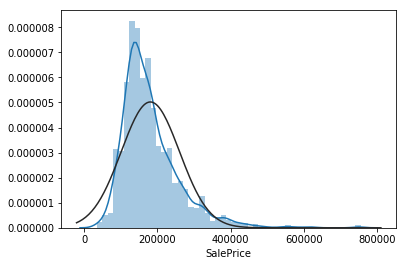

In [579]:
# 圖中可以看到資料不是成常態分佈

from scipy.stats import norm
from scipy import stats

sns.distplot(mydata['SalePrice'], fit=norm);
fig = plt.figure()

In [580]:
# 將售價通過log讓他更接近常態分佈

mydata['SalePrice'] = np.log(mydata['SalePrice'])+1

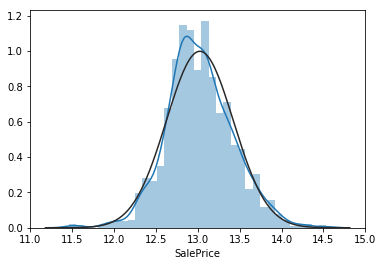

In [581]:
# 可以看到通過log後的售價更接近常態分布

sns.distplot(mydata['SalePrice'], fit=norm);
fig = plt.figure()

In [582]:
df = df.fillna(0)

In [583]:
X = np.array(df)
y_train = 1+np.array(mydata['SalePrice'])

In [589]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_log_error
#from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_log_error

rgr_ls = Lasso(fit_intercept = True)
param_grid = {
    "alpha": [0.0002, 0.0003, 0.0005, 0.0008, 0.001]
}
searchCV = GridSearchCV(rgr_ls, cv=5, param_grid=param_grid, scoring='neg_mean_squared_error')
searchCV.fit(X, y_train)
np.sqrt(searchCV.best_score_*-1)
    

C:\Users\kevin01258511\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kevin01258511\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kevin01258511\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kevin01258511\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\coo

0.1968794969484558

# Submission

In [612]:
scoredata = pd.read_csv('test_.csv')
del scoredata["A"]

scoredata = scoredata.fillna(0)

In [614]:
data = pd.read_csv('id_.csv')
Id = data["Id"]

y_test_pred = searchCV.predict(scoredata)
y_test_pred = np.exp(y_test_pred-1)

my_submission = pd.DataFrame({'Id': Id, 'SalePrice': y_test_pred})
my_submission.to_csv('submission.csv', index=False)

# 總結
原本照著自己的想法下去進行資料預處理但是結果非常不好，後來在kaggle其他作者和我有相似的encoding方式便拿來使用，然後在其他我沒想到的其他改善feature的方式也參考了另一個kernel的方法，最後模型評估分數得到了改善，最後只使用此競賽大部分kernel結果最好的Lasso來進行預測，如果要在更進一步改善可以用多個模型來平均預測結果，或是用kFold做cross_validation，其它前20%的作者皆用了這些方法，這裡僅將單一模型發揮到最大功能。

kaggle 排名

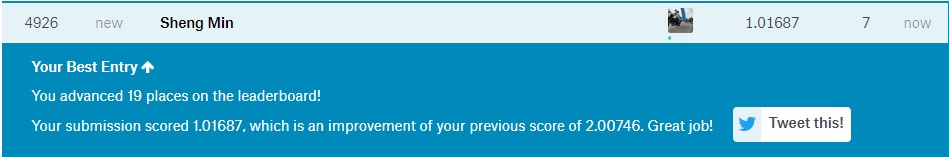

In [604]:
from IPython.display import Image
Image("k.jpg")